AIM makes use of a grid-grid interaction matrix,
$$
\mathrm{G} = \begin{pmatrix}
0 \\
G_1 & 0 \\
G_2 & G_1 & 0 \\
G_3 & G_2 & G_1 & 0 \\
G_4 & G_3 & G_2 & G_1 & 0 \\
0   & G_4 & G_3 & G_2 & G_1 & 0 \\
0   & 0   & G_4 & G_3 & G_2 & G_1 & 0
\end{pmatrix}
$$
where the $G_i$ have a three-level Toeplitz structure. The AIM specification paper details these $G_i$ as sparse propagation matricies of size $N_\text{grid} \times N_\text{grid}$ with entries
$$
G_{\ell - \ell'}^{ij} = \frac{T(t - r_{ij}/c)}{4 \pi r_{ij}}; \quad r_{ij} = \left| \mathbf{r}_j - \mathbf{r}_i \right|, t = (\ell - \ell') \, \Delta t.
$$
Taking $T(t)$ as the conventional Lagrange polynomial basis set,
$$
T(t) = \sum_{i = 0}^{p} \lambda_j(t); \qquad \lambda_j(t) = \frac{(1 - t)_j}{j!} \frac{(1 + t)_{p - j}}{(p - j)!} \text{ if } j - 1 \le t \lt j
$$

In [1]:
import itertools as it
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.special import poch, factorial
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

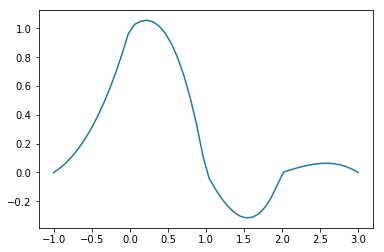

In [2]:
def lagrange_basis(t, order):
    def term(t, j):
        in_range = np.logical_and(j - 1 <= t, t < j)
        return in_range * (poch(1-t, j)/factorial(j) * poch(1 + t, order - j)/factorial(order - j))
    
    return sum([term(t, j) for j in range(order + 1)])

ts = np.linspace(-1, 3)
xs = lagrange_basis(ts, 3)
plt.plot(ts, xs)

...and a rectangular grid of equally-spaced points $(c = 1, \Delta x = 1)$...

In [3]:
nx, ny, nz = 2, 2, 11
pts = np.array(list(it.product(range(nx), range(ny), range(nz))))

...then the $G_1$ sub-matrix becomes

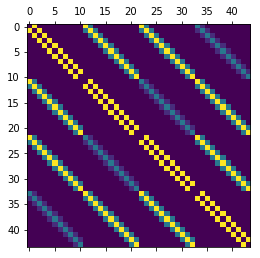

In [4]:
interp_order = 3

g1 = squareform(lagrange_basis(1 - pdist(pts), 3))
plt.matshow(g1)

Because the pairwise calculation "moves" the fastest along $z$, $G_1$ is Toeplitz in $z$ and block-Toeplitz in $x$ and $y$. Consequently, we can diagonalize the Toeplitz blocks with an FFT to accelerate matrix-vector products.

In [5]:
num_vecs = nx * ny
        
# Build the compressed, diagonal representation of g1
toeplitz_vectors = g1[0].reshape((num_vecs, nz))
circulant_vectors = np.bmat(
    [toeplitz_vectors, np.zeros([num_vecs, 1]), toeplitz_vectors[:, :0:-1]]
)

diag_circulant_vectors = np.fft.fft(circulant_vectors, axis=1)

# Build a dummy x (for g1.dot(x)) in the same basis as the compressed vectors above
test_x = np.arange(nx * ny * nz)
test_x_parts = test_x.reshape([num_vecs, nz])

diag_test_x_parts = np.fft.fft(np.bmat([test_x_parts, np.zeros([num_vecs, nz])]), axis=1)

In [6]:
# Move through the compressed diag_test_x_parts to perform a matrix-vector product
# on the block level

def fourier_idx(row, col):
    """This is the *heart* of AIM --- given a list of (nx * ny) stored vectors each of length (nz)
    corresponding to the values in a block-Toeplitz matrix, this function produces the vector index
    corresponding to a block at (row, column) in the full matrix"""
    src = (col // ny, col % ny)
    obs = (row // ny, row % ny)
    
    return ny * abs(obs[0] - src[0]) + abs(obs[1] - src[1])

diag_results = np.zeros([num_vecs, 2 * nz], dtype='complex128')

for row, col in it.product(range(num_vecs), range(num_vecs)):
    diag_results[row] += diag_circulant_vectors[fourier_idx(row, col)] * diag_test_x_parts[col]
    
results = np.fft.ifft(diag_results, axis=1)[:,:nz]
b_vec = np.real(np.concatenate(results))

In [7]:
print("FFT: ", b_vec)
print("Matrix/vector: ", g1.dot(test_x))
print("Full vector error: ", np.linalg.norm((b_vec - g1.dot(test_x))/g1.dot(test_x)))

FFT:  [  65.5892135    87.36765231   93.62617805   99.88470378  106.14322952
  112.40175526  118.660281    124.91880674  131.17733247  137.43585821
  105.0253367    70.77287763  102.13868438  108.39721012  114.65573586
  120.91426159  127.17278733  133.43131307  139.68983881  145.94836455
  152.20689029  110.20900084   75.95654177  116.90971645  123.16824219
  129.42676793  135.68529367  141.94381941  148.20234514  154.46087088
  160.71939662  166.97792236  115.39266498   81.14020591  131.68074853
  137.93927427  144.1978      150.45632574  156.71485148  162.97337722
  169.23190296  175.49042869  181.74895443  120.57632912]
Matrix/vector:  [  65.5892135    87.36765231   93.62617805   99.88470378  106.14322952
  112.40175526  118.660281    124.91880674  131.17733247  137.43585821
  105.0253367    70.77287763  102.13868438  108.39721012  114.65573586
  120.91426159  127.17278733  133.43131307  139.68983881  145.94836455
  152.20689029  110.20900084   75.95654177  116.90971645  123.168242